<a href="https://colab.research.google.com/github/NOKOGIDO/Time-to-Event/blob/main/Modelos/Nnet_Survival.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Nnet-Survival**

En este cuaderno se empleará el método Logistic Hazard, también conocido como Nnet-Survival.

Nnet-Survival es un método de tiempo discreto, es decir, es necesario discretizar la escala de tiempos.

In [ ]:
!git clone https://github.com/havakv/pycox.git

Cloning into 'pycox'...
remote: Enumerating objects: 1752, done.
remote: Counting objects: 100% (149/149), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 1752 (delta 81), reused 115 (delta 67), pack-reused 1603
Receiving objects: 100% (1752/1752), 2.51 MiB | 6.63 MiB/s, done.
Resolving deltas: 100% (1138/1138), done.


In [ ]:
! pip install sklearn-pandas

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# For preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

In [ ]:
!pip install pycox

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.7/73.7 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 44.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.3/412.3 kB 35.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.8/138.8 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.8/49.8 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 38.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 8.8 MB/s eta 0:00:00
  Created wheel for feather-format: filename=feather_format-0.4.1-py3-none-any.whl size=2435 sha256=e314f16e18e638e3db2e2e37f8a48dbbc3cb559610345141da9d85cef68fa24e
  Stored in directory: /root/.cache/pip/wheels/a6/ff/5d/4f10de26fe5ddef243

Pycox está construido sobre PyTorch y torchtuples, esto nos ayuda a entrenar redes neuronales con menos código repetitivo.

In [ ]:
import torch # For building the networks
import torchtuples as tt # Some useful functions

Importamos el dataset, el modelo LogisticHazard también conocido como Nnet-Survival y EvalSurv que simplifica el procedimiento de evaluación.

In [ ]:
from pycox.datasets import metabric
#from pycox.datasets import support
#from pycox.datasets import gbsg
from pycox.models import LogisticHazard
from pycox.evaluation import EvalSurv

In [ ]:
# We also set some seeds to make this reproducable.
# Note that on gpu, there is still some randomness.
np.random.seed(2587)
_ = torch.manual_seed(258)

# **Dataset**
Cargamos el dataset METABRIC (en este apartado podemos cambiar para seleccionar el dataset Rot. & GBSG o el dataset SUPPORT) y hacemos las particiones de entrenamiento, test y validación.

In [ ]:
df_train = metabric.read_df()
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

Dataset 'metabric' not locally available. Downloading...
Done


In [ ]:
df_train.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,duration,event
0,5.603834,7.811392,10.797988,5.967607,1.0,1.0,0.0,1.0,56.840000,99.333336,0
4,5.456747,5.339741,10.555724,6.008429,1.0,0.0,0.0,1.0,67.849998,56.933334,1
7,5.916774,5.289600,12.981733,6.009507,0.0,1.0,0.0,1.0,64.610001,143.000000,1
8,5.865741,6.738176,10.850687,5.596416,0.0,0.0,0.0,1.0,68.209999,150.600006,1
11,6.333529,5.170259,8.742507,6.500216,0.0,1.0,1.0,0.0,55.020000,141.166672,0


# **Transformación de Características**
Tenemos una serie de variables, además de las duraciones e indicadores de eventos.

Estandarizamos las variables numéricas y mantenemos las variables binarias. Las variables deben ser de tipo 'float32', ya que es necesario para el correcto funcionamiento de pytorch. Dependiendo del dataset seleccionado, debemos ajustar el número y tipo de variables, para su estandarización.

In [ ]:
cols_standardize = ['x0', 'x1', 'x2', 'x3', 'x8']
cols_leave = ['x4', 'x5', 'x6', 'x7']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

In [ ]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

# **Transformación de etiquetas**
Los métodos de supervivencia requieren transformaciones de etiquetas individuales, por lo que hemos incluido una **label_transform**, esta es solo una abreviatura de la clase **pycox.preprocessing.label_transforms.LabTransDiscreteTime.**

LogisticHazard es un método de tiempo discreto, lo que significa que requiere la discretización de los tiempos de los eventos para aplicarse a datos de tiempo continuo. Dejamos que **num_durations** defina el tamaño de esta cuadrícula de discretización (equidistante), lo que significa que nuestra red tendrá **num_durations** nodos de salida.

In [ ]:
num_durations = 10

labtrans = LogisticHazard.label_transform(num_durations)

get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))

train = (x_train, y_train)
val = (x_val, y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(df_test)

In [ ]:
type(labtrans)

pycox.preprocessing.label_transforms.LabTransDiscreteTime

La **labtrans.cuts** contiene la rejilla de discretización. Esto se utilizará posteriormente para obtener la escala de tiempo adecuada para las predicciones de supervivencia.

In [ ]:
labtrans.cuts

array([  0.      ,  37.303703,  74.60741 , 111.91111 , 149.21481 ,
       186.51852 , 223.82222 , 261.12592 , 298.42963 , 335.73334 ],
      dtype=float32)

Ahora, **y_train** es una tupla con los índices de los tiempos discretizados, además de indicadores de eventos.

In [ ]:
y_train

(array([2, 2, 4, ..., 4, 2, 5]),
 array([0., 1., 1., ..., 0., 1., 0.], dtype=float32))

In [ ]:
labtrans.cuts[y_train[0]]

array([ 74.60741,  74.60741, 149.21481, ..., 149.21481,  74.60741,
       186.51852], dtype=float32)

# **Neural Net**
Creamos un MLP simple (Perceptrón Multicapa) con dos capas ocultas, activación ReLU, Batch Norm y Dropout. Empleamos la red torchtuples.practical.MLPVanilla para hacer esto.

In [ ]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.1

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

# **Entrenamos el Modelo**
Para entrenar el modelo, es necesario definir un optimizador. En este caso se emplea **tt.optim** para la selección, ya que tiene alguna funcionalidad adicional. Se utiliza el optimizador Adam, con una tasa de aprendizaje de 0,01. Se configura el índice de duración que conecta los nodos de salida de la red con os tiempos de discretización. Esto solo es necesario para la predicción y no es necesario para el proceso de entrenamiento.

In [ ]:
model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)

A continuación, configuramos el tamaño del lote (**batch size**) y el número de **epochs** para el entrenamiento. También se incluye **EarlyStoping** para detener el entrenamiento cuando la función de pérdida de validación deje de mejorar.

In [ ]:
batch_size = 256
epochs = 100
callbacks = [tt.cb.EarlyStopping()]

Podemos entrenar la red y el log de registro realiza un seguimiento del progreso del entrenamiento.

In [ ]:
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

0:	[0s / 0s],		train_loss: 3.0470,	val_loss: 3.2464
1:	[0s / 0s],		train_loss: 2.7535,	val_loss: 2.9236
2:	[0s / 0s],		train_loss: 2.4895,	val_loss: 2.4485
3:	[0s / 0s],		train_loss: 2.1745,	val_loss: 1.9600
4:	[0s / 0s],		train_loss: 1.8322,	val_loss: 1.6392
5:	[0s / 0s],		train_loss: 1.6023,	val_loss: 1.4765
6:	[0s / 0s],		train_loss: 1.4929,	val_loss: 1.4163
7:	[0s / 0s],		train_loss: 1.4565,	val_loss: 1.4005
8:	[0s / 0s],		train_loss: 1.4237,	val_loss: 1.4019
9:	[0s / 0s],		train_loss: 1.4120,	val_loss: 1.4022
10:	[0s / 0s],		train_loss: 1.3729,	val_loss: 1.4051
11:	[0s / 0s],		train_loss: 1.3716,	val_loss: 1.3968
12:	[0s / 0s],		train_loss: 1.3693,	val_loss: 1.3863
13:	[0s / 0s],		train_loss: 1.3392,	val_loss: 1.3913
14:	[0s / 0s],		train_loss: 1.3404,	val_loss: 1.4039
15:	[0s / 0s],		train_loss: 1.3478,	val_loss: 1.3949
16:	[0s / 0s],		train_loss: 1.3360,	val_loss: 1.3905
17:	[0s / 0s],		train_loss: 1.3234,	val_loss: 1.3980
18:	[0s / 0s],		train_loss: 1.3162,	val_loss: 1.4051
19:

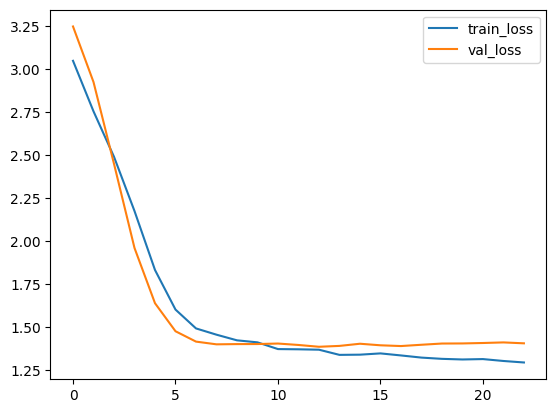

In [ ]:
_ = log.plot()


Después de la ejecución, la devolución de llamada **EarlyStopping** carga el modelo con mejor rendimiento (en términos de pérdida de validación). Podemos verificar esto comparando la pérdida mínima de validación con la puntuación de validación del modelo entrenado.

In [ ]:
log.to_pandas().val_loss.min()

1.3862766027450562

In [ ]:
model.score_in_batches(val)

{'loss': 1.3862766027450562}

# **Predicción**
Para la evaluación, primero necesitamos obtener estimaciones de supervivencia para el conjunto de prueba. Esto se puede hacer con **model.predict_surv** que devuelve una serie de estimaciones de supervivencia, o con **model.predict_surv_df** que devuelve las estimaciones de supervivencia como un marco de datos.

In [ ]:
surv = model.predict_surv_df(x_test)

Podemos trazar las estimaciones de supervivencia para los primeros 5 individuos. Tenga en cuenta que la escala de tiempo es correcta porque hemos configurado **model.duration_index** para que sean los puntos de la cuadrícula. Sin embargo, solo hemos definido las estimaciones de supervivencia en los 10 tiempos de nuestra cuadrícula de discretización, por lo que las estimaciones de supervivencia son una función escalonada.

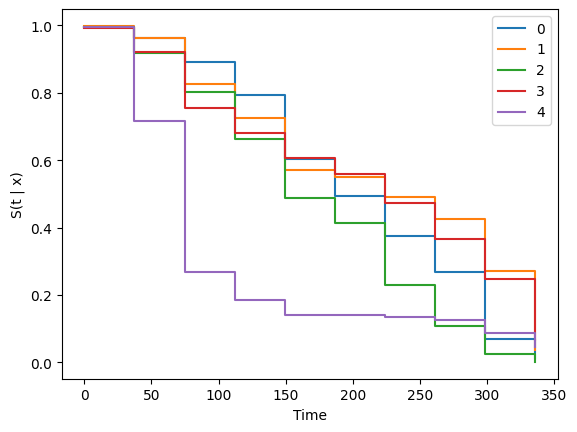

In [ ]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

Por lo tanto, a menudo resulta beneficioso interpolar las estimaciones de supervivencia. La interpolación lineal (interpolación de densidad constante) se puede realizar con el **interpolate method**. También debemos elegir con cuántos puntos queremos reemplazar cada punto de la cuadrícula. Ella usaremos 10.

In [ ]:
surv = model.interpolate(10).predict_surv_df(x_test)

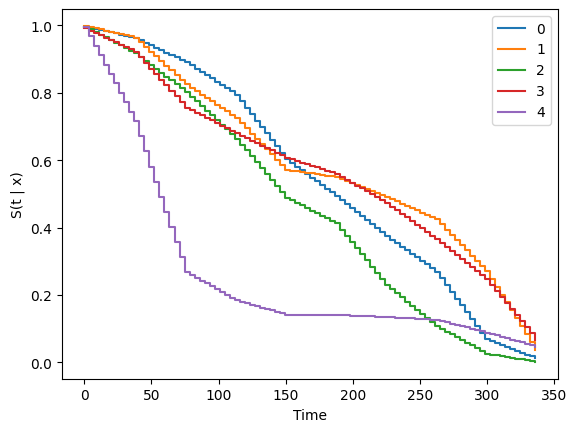

In [ ]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

# **Evaluación**
La clase **EvalSurv** contiene algunos criterios de evaluación útiles para la predicción del tiempo hasta el evento. Configuramos **censor_surv = 'km'** para indicar que queremos usar **Kaplan-Meier** para estimar la distribución de censura.

In [ ]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


# **Concordancia**
Comenzamos con la concordancia **event-time** de  [Antolini et al. 2005](https://onlinelibrary.wiley.com/doi/10.1002/sim.2427).

In [ ]:
ev.concordance_td('antolini')

0.6424213297672281

# **Brier Score**
Podemos trazar la puntuación de [IPCW Brier](https://onlinelibrary.wiley.com/doi/abs/10.1002/%28SICI%291097-0258%2819990915/30%2918%3A17/18%3C2529%3A%3AAID-SIM274%3E3.0.CO%3B2-5) para un conjunto de tiempos determinado. Aquí solo usamos 100 puntos de tiempo entre la duración mínima y máxima en el conjunto de prueba. Tenga en cuenta que la puntuación se vuelve inestable para los tiempos más altos. Por lo tanto, es común ignorar la parte más derecha del gráfico.

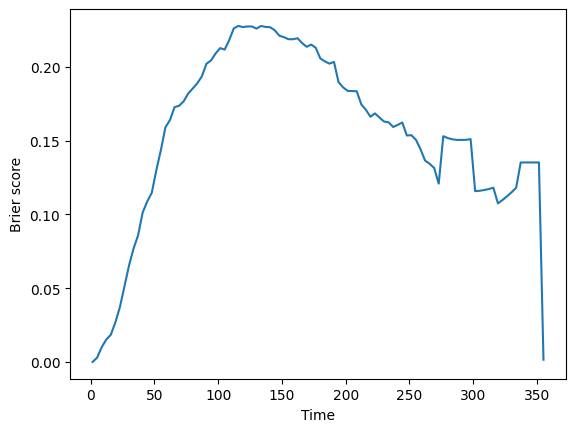

In [ ]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

# **Negative binomial log-likelihood**
De manera similar, podemos trazar el [IPCW negative binomial log-likelihood](https://onlinelibrary.wiley.com/doi/abs/10.1002/%28SICI%291097-0258%2819990915/30%2918%3A17/18%3C2529%3A%3AAID-SIM274%3E3.0.CO%3B2-5).

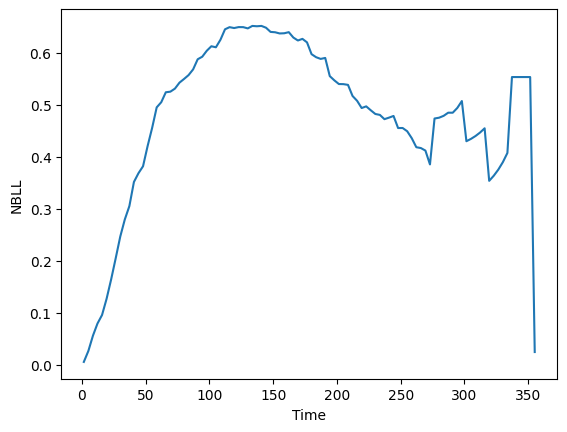

In [ ]:
ev.nbll(time_grid).plot()
plt.ylabel('NBLL')
_ = plt.xlabel('Time')

# **Integrated scores**
Las dos puntuaciones anteriores dependientes del tiempo se pueden integrar a lo largo del tiempo para producir una puntuación única [Graf et al. 1999](https://onlinelibrary.wiley.com/doi/abs/10.1002/%28SICI%291097-0258%2819990915/30%2918%3A17/18%3C2529%3A%3AAID-SIM274%3E3.0.CO%3B2-5). En la práctica, esto se hace mediante integración numérica sobre una **cuadrícula de tiempo** definida.

In [ ]:
ev.integrated_brier_score(time_grid)

0.15638295047012477

In [ ]:
ev.integrated_nbll(time_grid)

0.48373869617215176